# Prediction with pre-trained CNNs
This notebook contains all the code you need to use a pre-trained OpenSoundscape convolutional neural network model (CNN) to make predictions on your own data. Before attempting this tutorial, install OpenSoundscape by following the instructions on the OpenSoundscape website, [opensoundscape.org](http://opensoundscape.org/). More detailed tutorials about data preprocessing, training CNNs, and customizing prediction methods can also be found on this site.

## Load required packages

We will load several imports from OpenSoundscape. First, load the `AudiotoSpectrogramPreprocessor` class from the `preprocess.preprocessors` module. Preprocessor classes are used to load, transform, and augment audio samples for use in a machine learning model. 

In [1]:
from opensoundscape.preprocess.preprocessors import AudioToSpectrogramPreprocessor

Second, the `cnn` module provides classes for training and prediction with various structures of CNNs. For this example, load the `Resnet18Binary` class, used for models made with the Resnet18 architecture for predicting the presence or absence of a species (a "binary" classifier).

In [2]:
# The cnn module provides classes for training/predicting with various types of CNNs
from opensoundscape.torch.models.cnn import Resnet18Binary

Finally, load some additional packages and perform some setup for the Jupyter notebook.

In [3]:
# Other utilities and packages
import torch
from pathlib import Path
import numpy as np
import pandas as pd
from glob import glob
import subprocess

In [4]:
#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

## Prepare audio data for prediction

To run predictions on your audio data, you will need to have your audio already split up into the clip lengths that the model expects to receive. If your audio data are not already split, see the demonstration of the `Audio.split()` method in the `audio_and_spectrogram` notebook.

You can check the length of clips that the model to receives in the model's notes when you download it. This is often, but not always, 5.0 seconds.

### Download audio files

The Kitzes Lab has created a small labeled dataset of short clips of American Woodcock vocalizations. You have two options for obtaining the folder of data, called `woodcock_labeled_data`:

1. Run the following cell to download this small dataset. These commands require you to have `curl` and `tar` installed on your computer, as they will download and unzip a compressed file in `.tar.gz` format. 

2. OR download a `.zip` version of the files by clicking [here](https://pitt.box.com/shared/static/m0cmzebkr5qc49q9egxnrwwp50wi8zu5.zip). You will have to unzip this folder and place the unzipped folder in the same folder that this notebook is in.

**Note**: Once you have the data, you do not need to run this cell again.

In [5]:
subprocess.run(['curl','https://pitt.box.com/shared/static/79fi7d715dulcldsy6uogz02rsn5uesd.gz','-L', '-o','woodcock_labeled_data.tar.gz']) # Download the data
subprocess.run(["tar","-xzf", "woodcock_labeled_data.tar.gz"]) # Unzip the downloaded tar.gz file
subprocess.run(["rm", "woodcock_labeled_data.tar.gz"]) # Remove the file after its contents are unzipped

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     7    0     7    0     0      7      0 --:--:-- --:--:-- --:--:--     7
100 4031k  100 4031k    0     0  1682k      0  0:00:02  0:00:02 --:--:-- 3948k


CompletedProcess(args=['rm', 'woodcock_labeled_data.tar.gz'], returncode=0)

### Generate a Preprocessor object

In addition to having audio clips of the correct length, you will need to create a Preprocessor object that loads audio samples for the CNN. 

First, generate a Pandas DataFrame with the index containing the paths to each file, as shown below.

In [6]:
# collect a list of audio files
file_list = glob('./woodcock_labeled_data/*.wav')

# create a DataFrame with the audio files as the index
audio_file_df = pd.DataFrame(index=file_list)

Next, use that DataFrame to create a Preprocessor object suitable for your application. Use the argument `return_labels=False`, as our audio to predict on does not have labels.

If the model was trained with any special preprocesor settings, you should apply those settings here. For pretrained models created by the Kitzes Lab, see the model's notes from its download page for the exact code to use here.

In [7]:
# create a Preprocessor object 
# we use the option "return_labels=False" because our audio to predict on does not have labels
from opensoundscape.preprocess.preprocessors import AudioToSpectrogramPreprocessor
prediction_dataset = AudioToSpectrogramPreprocessor(audio_file_df, return_labels=False)

## Models trained with OpenSoundscape v0.5.x and above
Check the model notes page for the appropriate model class to use and import the correct class from the `cnn` module.

In [8]:
from opensoundscape.torch.models.cnn import Resnet18Binary

For the purpose of demonstration, let's generate a new Resnet18 model for binary prediction and save it to our local folder. This is a dummy model that will not be trained using any data and will thus not make meaningful predictions.

If you download a pre-trained model, you can skip this cell.

In [9]:
model = Resnet18Binary(classes=['absent','present'])
model.save('./demo.model')

created PytorchModel model object with 2 classes
Saving to demo.model


In [10]:
from opensoundscape.torch.models.cnn import PytorchModel

Next, provide the model class's `from_checkpoint()` method with the path to your downloaded model.

In [11]:
# load the model into the appropriate model class
model = Resnet18Binary.from_checkpoint('./demo.model')

created PytorchModel model object with 2 classes
loading weights from saved object


Generate predictions as follows. The `predict` method returns three arguments: scores, thresholded predictions, and labels. For unthresholded prediction on unlabeled data, only the first one is relevant, so we can discard the other returns using `scores, _, _`.

In [12]:
# call model.predict() with the Preprocessor to generate predictions
scores, _, _ = model.predict(prediction_dataset)

(29, 2)


Look at the scores of the first 5 samples. These scores may be anything from negative to positive infinity.

In [13]:
#look at the scores of the first 5 samples
scores.head()

,absent,present
./woodcock_labeled_data/d4c40b6066b489518f8da83af1ee4984.wav,0.970459,-0.622744
./woodcock_labeled_data/e84a4b60a4f2d049d73162ee99a7ead8.wav,0.894215,-0.192513
./woodcock_labeled_data/79678c979ebb880d5ed6d56f26ba69ff.wav,0.921353,-0.223057
./woodcock_labeled_data/49890077267b569e142440fa39b3041c.wav,0.898475,-0.475426
./woodcock_labeled_data/0c453a87185d8c7ce05c5c5ac5d525dc.wav,1.026837,-0.321966


### Options for prediction

The code above returns the raw predictions of the model without any post-processing (such as a softmax layer or a sigmoid layer). 

For details on how to use the `predict()` function for post-processing of predictions and to generate binary 0/1 predictions of class presence, see the "Basic training and prediction with CNNs" tutorial notebook. But, as a quick example, let's add a softmax layer to make the prediction scores for both classes sum to 1. We can also use the `binary_preds` argument to generate 0/1 predictions for each sample and class. For presence/absence models, use the option `binary_preds='single_target'`. For multi-class models, think about whether each clip should be labeled with only one class (single target) or whether each clip could contain multiple classes (`binary_preds='multi_target'`)

In [14]:
scores, binary_predictions, _ = model.predict(
    prediction_dataset,
    activation_layer='softmax',
    binary_preds='single_target'
)

(29, 2)


As before, the `scores` are continuous variables, but now have been softmaxed:

In [15]:
scores.head()

,absent,present
./woodcock_labeled_data/d4c40b6066b489518f8da83af1ee4984.wav,0.831066,0.168934
./woodcock_labeled_data/e84a4b60a4f2d049d73162ee99a7ead8.wav,0.747765,0.252235
./woodcock_labeled_data/79678c979ebb880d5ed6d56f26ba69ff.wav,0.758488,0.241512
./woodcock_labeled_data/49890077267b569e142440fa39b3041c.wav,0.798010,0.201990
./woodcock_labeled_data/0c453a87185d8c7ce05c5c5ac5d525dc.wav,0.793934,0.206066


We also have an additional output, the binary 0/1 ("absent" vs "present") predictions generated by the model:

In [16]:
binary_predictions.head()

,absent,present
./woodcock_labeled_data/d4c40b6066b489518f8da83af1ee4984.wav,1.0,0.0
./woodcock_labeled_data/e84a4b60a4f2d049d73162ee99a7ead8.wav,1.0,0.0
./woodcock_labeled_data/79678c979ebb880d5ed6d56f26ba69ff.wav,1.0,0.0
./woodcock_labeled_data/49890077267b569e142440fa39b3041c.wav,1.0,0.0
./woodcock_labeled_data/0c453a87185d8c7ce05c5c5ac5d525dc.wav,1.0,0.0


It is often helpful to look at a histogram of the scores for the positive class. Because this dummy model had random weights, we would expect this histogram to center somewhere around 0.5.

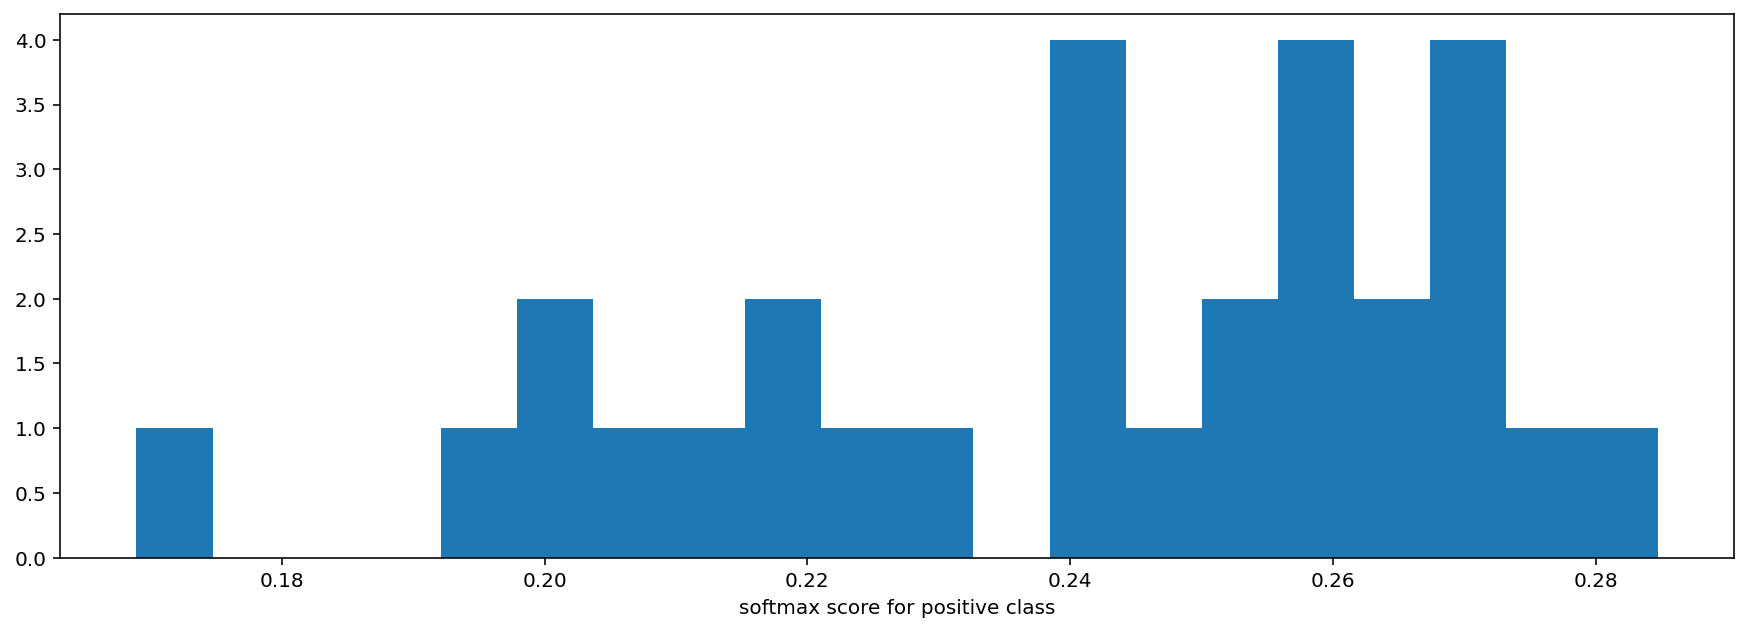

In [17]:
_ = plt.hist(scores['present'],bins=20)
_ = plt.xlabel('softmax score for positive class')

## Prediction on long (un-split) audio files

It's also possible to run predictions on long audio files. In this case, OpenSoundscape will internally split the audio into short segments during prediction. The input and output of prediction is slightly different in this case:
- Input is a dataframe containing file paths as the index, with columns for `start_time` and `end_time` of each clip that should be used as a sample for predictions
- Output only contains the file paths, but has multiple entries for file. You must re-add the temporal information. 

still a dataframe, but it will have three "index" columns. The first matches the index of the input, and contains the audio file paths. The second and third index columns contain the "begin" and "end" time of clips relative to the start of the audio file. The remaining columns, as usual, contain the names of each class and the scores or predictions for each class for that row's audio clip. 

Let's look at an example. We'll use the 1 minute audio file contained within OpenSoundscape's test folder as a "long" audio file. In practice you can easily split very long (eg 3 hour) files without any additional overhead. 

In [18]:
import opensoundscape
from opensoundscape.preprocess.preprocessors import ClipLoadingSpectrogramPreprocessor
from pathlib import Path
import pandas as pd

#get audio path from opensoundscape's tests folder
audio_1m_path = Path(opensoundscape.__file__).parent.parent.joinpath('tests/audio/1min.wav')


#generate a dataframe that lists the clip times for each audio path
from opensoundscape.helpers import generate_clip_times_df
import librosa
clip_dfs = []
files = [audio_1m_path]
clip_length = 5.0
clip_overlap = 0.0
for f in files:
    t = librosa.get_duration(filename=f)
    clips = generate_clip_times_df(t,clip_length,clip_overlap)     
    clips.index = [f]*len(clips)
    clips.index.name = 'file'
    clip_dfs.append(clips)
clip_dfs = pd.concat(clip_dfs)

generate preprocessor

In [19]:
preprocessor = ClipLoadingSpectrogramPreprocessor(clip_dfs)

In [20]:
score_df, _, _ = model.predict(preprocessor)

#we need to re-add the time information about each of these clips
score_df.index = pd.MultiIndex.from_arrays([clip_dfs.index,clip_dfs['start_time'],clip_dfs['end_time']])

score_df

/Users/SML161/opensoundscape/opensoundscape/torch/models/cnn.py:632: UserWarning: The columns of prediction_dataset.df differfrom model.classes
  "The columns of prediction_dataset.df differ" "from model.classes"


(12, 2)


absent  \
file                                              start_time end_time             
/Users/SML161/opensoundscape/tests/audio/1min.wav 0.0        5.0       1.063462   
                                                  5.0        10.0      0.621790   
                                                  10.0       15.0      0.686997   
                                                  15.0       20.0      0.641979   
                                                  20.0       25.0      0.830157   
                                                  25.0       30.0      0.487957   
                                                  30.0       35.0      0.582767   
                                                  35.0       40.0      0.679886   
                                                  40.0       45.0      0.953645   
                                                  45.0       50.0      0.571868   
                                                  50.0       55.0      0.446422   
                                                  55.0       60.0      0.362575   

                                                                        present  
file                                              start_time end_time            
/Users/SML161/opensoundscape/tests/audio/1min.wav 0.0        5.0       0.431290  
                                                  5.0        10.0      0.152131  
                                                  10.0       15.0      0.081881  
                                                  15.0       20.0      0.219291  
                                                  20.0       25.0     -0.128708  
                                                  25.0       30.0     -0.002815  
                                                  30.0       35.0      0.194452  
                                                  35.0       40.0      0.057393  
                                                  40.0       45.0      0.219515  
                                                  45.0       50.0      0.066121  
                                                  50.0       55.0     -0.050509  
                                                  55.0       60.0      0.029591

## Deprecated: Using LongAudioPreprocessor to predict on long (un-split) audio files

It's also possible to run predictions on long audio files by loading entire files and letting OpenSoundscape split them while predicting. This is deprecated in favor of the approach shown above and has high memory (RAM) requirements. In this case, OpenSoundscape will internally split the audio into short segments during prediction. The input and output of prediction is slightly different in this case:
- Input is similar to regular prediction: a dataframe with the index containing the paths to audio files
- Output is still a dataframe, but it will have three "index" columns. The first matches the index of the input, and contains the audio file paths. The second and third index columns contain the "begin" and "end" time of clips relative to the start of the audio file. The remaining columns, as usual, contain the names of each class and the scores or predictions for each class for that row's audio clip. 

Let's look at an example. We'll use the 1 minute audio file contained within OpenSoundscape's test folder as a "long" audio file. In practice, you can split files that are multiple hours long - the limiting factor is your computer's memory ("RAM"), which must be able to hold the entire audio file. 

In [21]:
import opensoundscape
from opensoundscape.preprocess.preprocessors import LongAudioPreprocessor

#get audio path from opensoundscape's tests folder
audio_1m_path = Path(opensoundscape.__file__).parent.parent.joinpath('tests/audio/1min.wav')
long_audio_prediction_df = pd.DataFrame(index=[audio_1m_path])
img_shape = [224,224]

#the audio will be split during prediction. choose the clip length and overlap of sequential clips (0 for no overlap)
clip_length = 5.0
clip_overlap = 0.0
long_audio_prediction_ds = LongAudioPreprocessor(
    long_audio_prediction_df,
    audio_length=clip_length, 
    clip_overlap=clip_overlap, 
    out_shape=img_shape, 
)


/Users/SML161/opt/miniconda3/envs/opso/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated class LongAudioPreprocessor. (Use ClipLoadingSpectrogramPreprocessorfor similar functionality with lower memory requirements.) -- Deprecated since version 0.6.1.
  app.launch_new_instance()


in addition to the scores (and potentially, predictions) the function returns a list of "unsafe" samples that caused errors during preprocessing. 

In [22]:
score_df, pred_df, unsafe_samples = model.split_and_predict(
    long_audio_prediction_ds,
    file_batch_size=1,
    num_workers=0,
    activation_layer=None,
    binary_preds='single_target',
    threshold=0.5,
    clip_batch_size=4,
    error_log=None,
)
score_df.head()

/Users/SML161/opt/miniconda3/envs/opso/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated method split_and_predict. (Use ClipLoadingSpectrogramPreprocessorwith model.predict() for similar functionality but lower memory requirements.) -- Deprecated since version 0.6.1.
  if __name__ == '__main__':


absent  \
file                                              start_time end_time             
/Users/SML161/opensoundscape/tests/audio/1min.wav 0.0        5.0       1.063462   
                                                  5.0        10.0      0.621789   
                                                  10.0       15.0      0.686997   
                                                  15.0       20.0      0.641979   
                                                  20.0       25.0      0.830157   

                                                                        present  
file                                              start_time end_time            
/Users/SML161/opensoundscape/tests/audio/1min.wav 0.0        5.0       0.431290  
                                                  5.0        10.0      0.152131  
                                                  10.0       15.0      0.081881  
                                                  15.0       20.0      0.219291  
                                                  20.0       25.0     -0.128708

## Models trained with OpenSoundscape 0.4.x
One set of our publicly availably [binary models for 500 species](https://pitt.app.box.com/s/3048856qbm9x55yi3zfksa3fide5uuf4) was created with an older version of OpenSoundscape. These models require a little bit of manipulation to load into OpenSoundscape 0.5.x and onward.

First, let's download one of these models (it's stored in a .tar format) and save it to the same directory as this notebook in a file called `opso_04_model_acanthis-flammea.tar`

In [23]:
subprocess.run(['curl',
               'https://pitt.box.com/shared/static/lglpty35omjhmq6cdz8cfudm43nn2t9f.tar', 
                '-L', '-o', 'opso_04_model_acanthis-flammea.tar'])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     8    0     8    0     0      6      0 --:--:--  0:00:01 --:--:--     0
100 42.9M  100 42.9M    0     0  5079k      0  0:00:08  0:00:08 --:--:-- 8461k


CompletedProcess(args=['curl', 'https://pitt.box.com/shared/static/lglpty35omjhmq6cdz8cfudm43nn2t9f.tar', '-L', '-o', 'opso_04_model_acanthis-flammea.tar'], returncode=0)

Next, load the weights from that model into an OpenSoundscape model object with the following code:

In [24]:
from opensoundscape.torch.models.cnn import PytorchModel
from opensoundscape.torch.architectures.cnn_architectures import resnet18
import torch

# load the tar file into a dictionary 
# (you could change this to the location of any .tar file on your computer)
opso_04_model_tar_path = "./opso_04_model_acanthis-flammea.tar"
opso_04_model_dict = torch.load(opso_04_model_tar_path)

# create a resnet18 binary model 
# (all models created with Opensoundscape 0.4.x are 2-class resnet18 architectures)
architecture = resnet18(num_classes=2,use_pretrained=False)
model = PytorchModel(classes=['negative','positive'],architecture=architecture)

# load the model weights into our model object
# now, our model is equivalent to the trained model we downloaded
model.network.load_state_dict(opso_04_model_dict['model_state_dict'])

created PytorchModel model object with 2 classes


<All keys matched successfully>

Now, we can use the model as normal to create predictions on audio. We'll use the same `prediction_dataset` from above (which does not contain any Common redpoll).

Remember to choose the `activation_layer` you desire. In this example, we'll assume we just want to generate scores, not binary predictions. We'll apply a softmax layer, then the logit transform, to the scores using the `activation_layer="softmax_and_logit"` option. This will generate the type of scores that are useful for plotting score histograms, among other things. 

In [25]:
# generate predictions on our dataset
predition_scores_df,_,_ = model.predict(prediction_dataset, activation_layer='softmax')
predition_scores_df.head()

(29, 2)


,negative,positive
./woodcock_labeled_data/d4c40b6066b489518f8da83af1ee4984.wav,0.999635,0.000365
./woodcock_labeled_data/e84a4b60a4f2d049d73162ee99a7ead8.wav,0.995471,0.004529
./woodcock_labeled_data/79678c979ebb880d5ed6d56f26ba69ff.wav,0.999205,0.000795
./woodcock_labeled_data/49890077267b569e142440fa39b3041c.wav,0.988181,0.011819
./woodcock_labeled_data/0c453a87185d8c7ce05c5c5ac5d525dc.wav,0.999559,0.000441


Remove the downloaded files to clean up.

In [26]:
folder = Path('./woodcock_labeled_data')
[p.unlink() for p in folder.glob("*")]
folder.rmdir()
for p in Path('.').glob('*.model'):
    p.unlink()
for p in Path('.').glob('*.tar'):
    p.unlink()